In [5]:
%run init_notebook.py

In [28]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *

In [9]:
# Load data
model_type = "ols"
data_len = 8055 # 440, 660, 760, 1560, 8055
is_sent = False
week_day = 'daily'
predicted = "sp_close_lead1"

year_start = 2017
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

In [10]:
if week_day == 'daily':
    assert is_sent is False, 'Treating non sentiment data'
    # training on X years
    df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
             &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
    print(f'data compromises {year_end - year_start + 1} years: {df_w.shape[0]} lines')
else:
    year_spread = 'yearsNA'
    df_w = cut_to_weekly_data(df_w, 'is_thu')

data compromises 5 years: 1168 lines


In [11]:
# update dict with model specific information
data_dict["model_features"].update(predicted=predicted)
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(week_day=week_day)
data_dict["model_metrics"].update(year_spread=year_spread)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{year_spread}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# data selection

In [12]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    # 'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     # 'fears35',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
     'sp_close_lag8',
     'sp_close_lag9',
     'sp_close_lag10'
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [13]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [14]:
df_train = df_ws.copy()

In [15]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.3,
                                            add_const=False)

# Sesonality

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
## SEASONALITY DF
# create sub dataframe of X_train
X_train_sea = X_train.copy()

# insert datetime information
X_train_sea["date"] = pd.Series(X_train_sea.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x]).values
X_train_sea["weekday"] = is_day(X_train_sea.date)
X_train_sea["week"] = X_train_sea.date.apply(lambda x: apply_date_to_week(x))

# filter for complete weeks only
_ = X_train_sea.groupby("week").weekday.count() == 5
_ = _[_].index
X_train_sea = X_train_sea[X_train_sea["week"].isin(_)]

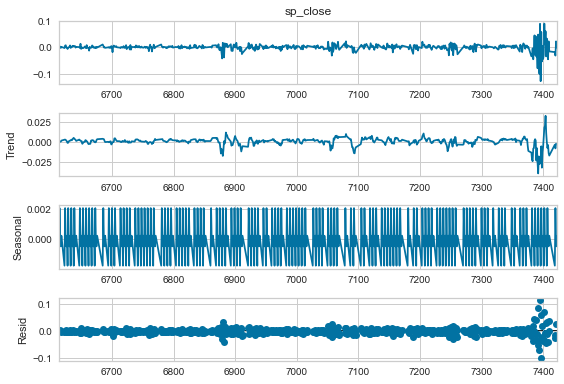

In [18]:
## SEASONALITY ANALYSIS
if week_day == "daily":
    # create statsmodel seasonality object
    sd = seasonal_decompose(X_train_sea.sp_close, period=5)
    sd.plot()
    plt.show()

    # get seasonality by weekday
    X_train_sea["seasonal"] = sd.seasonal
    data_dict["model_features"].update(weekday_seasonality= dict(zip(X_train_sea.groupby("weekday").seasonal.first().index, X_train_sea.groupby("weekday").seasonal.first().values)))

    # map sesonality to data
    _ = pd.Series(X_test.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_test["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    _ = pd.Series(X_train.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_train["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    cols.append("seasonal")

# Corr

In [19]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Lag corr

In [20]:
df_cross_corr(X_train,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]],
              data_dict["model_features"]["predicted"],
              show_plot=False,
              no_lags=20,
              figsize=(6, 3))

[['ff_M_RF', 6, 0.301],
 ['ff_SMB', 2, 0.155],
 ['ff_HML', 6, 0.144],
 ['ff_RMW', 18, 0.084],
 ['ff_CMA', 2, 0.135],
 ['seasonal', 18, 0.091]]

In [21]:
# X_train, _ = shift_var_relative_to_df(X_train,
#                                       shift_var=['ff_M_RF',
#                                                  'ff_SMB',
#                                                  'ff_HML',
#                                                  'ff_RMW',
#                                                  'ff_CMA'],
#                                       no_lags=[6, 4, 1, 6, 2])

# X_test, _ = shift_var_relative_to_df(X_test,
#                                       shift_var=['ff_M_RF',
#                                                  'ff_SMB',
#                                                  'ff_HML',
#                                                  'ff_RMW',
#                                                  'ff_CMA'],
#                                       no_lags=[6, 4, 1, 6, 2])

# data_dict["data_transformation"].update(shift_var=_)
# X_train = X_train.dropna()
# X_test = X_test.dropna()

Corr matrix

In [22]:
## ORTHOGONALISE
X_train = orthogonalise_vars(X_train, X="sp_close", y="ff_M_RF", show_fig=False)
X_train = orthogonalise_vars(X_train, X="ff_SMB", y="ff_M_RF", show_fig=False)

,VIF,corr_sp_close_lead1
sp_close,1.439682,-0.270756
sp_close_lag7,1.290124,-0.261681
sp_close_lag5,1.236204,-0.203473
ff_HML,1.651020,-0.119351
sp_close_lag9,1.311627,-0.092429
sp_close_lag3,1.341154,-0.088999
seasonal,1.032262,-0.020472
ff_M_RF,1.071156,-0.015804
sp_close_lag10,1.324742,-0.008479
ff_RMW,1.063264,0.007449


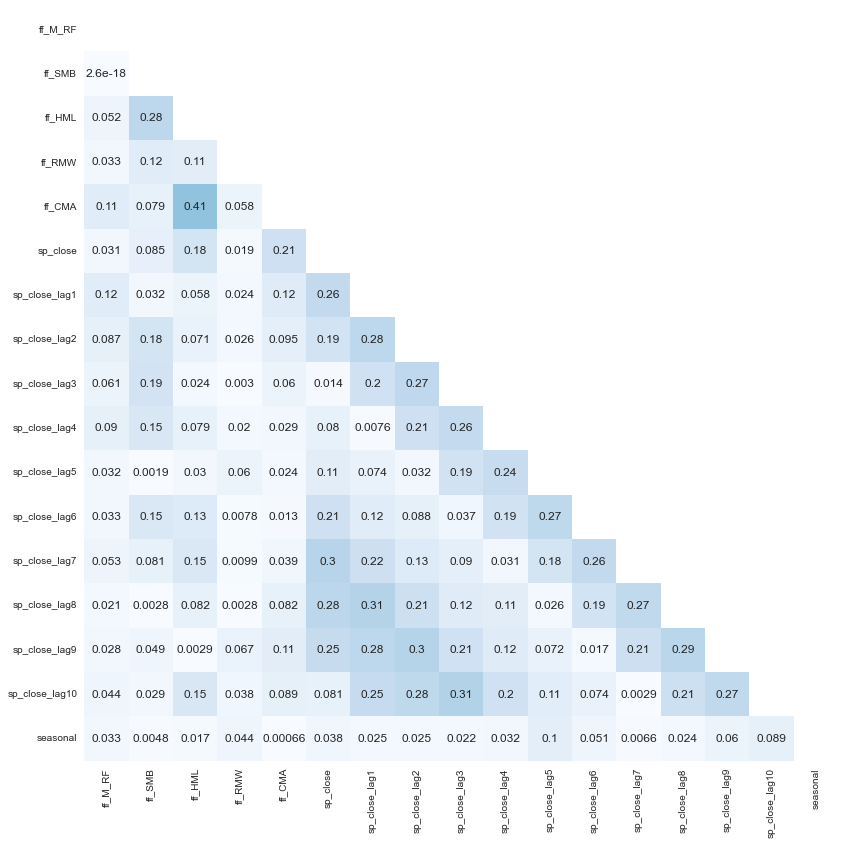

In [23]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             # size_factor=1,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

# Model

In [24]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [25]:
model = SKLearnWrap(sm.OLS, fit_intercept=True)
model_ = model.fit(X_train, y_train)

In [26]:
data_dict["model_metrics"].update(featuer_sig=model.results_.pvalues)
model.results_.pvalues < .05

ff_M_RF           False
ff_SMB             True
ff_HML             True
ff_RMW            False
ff_CMA            False
sp_close           True
sp_close_lag1      True
sp_close_lag2      True
sp_close_lag3      True
sp_close_lag4     False
sp_close_lag5      True
sp_close_lag6      True
sp_close_lag7      True
sp_close_lag8      True
sp_close_lag9     False
sp_close_lag10    False
seasonal          False
intercept         False
dtype: bool

In [27]:
model.results_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     13.85
Date:                Tue, 22 Mar 2022   Prob (F-statistic):           6.10e-35
Time:                        09:33:24   Log-Likelihood:                 2481.4
No. Observations:                 818   AIC:                            -4927.
Df Residuals:                     800   BIC:                            -4842.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
ff_M_RF            0.0005      0.002      0.254      0.799      -0.003       0.004
ff_SMB             0.0023      0.001      3.000      0.003       0.001       0.004
ff_HML            -0.0026      0.001     -3.453      0.001      -0.004      -0.001
ff_RMW             0.0018      0.001      1.544      0.123      -0.000       0.004
ff_CMA             0.0013      0.001      0.886      0.376      -0.002       0.004
sp_close          -0.1095      0.037     -2.936      0.003      -0.183      -0.036
sp_close_lag1      0.1234      0.036      3.403      0.001       0.052       0.195
sp_close_lag2      0.1308      0.036      3.667      0.000       0.061       0.201
sp_close_lag3     -0.0903      0.036     -2.514      0.012      -0.161      -0.020
sp_close_lag4     -0.0129      0.036     -0.361      0.718      -0.083       0.057
sp_close_lag5     -0.1114      0.035     -3.181      0.002      -0.180      -0.043
sp_close_lag6      0.1906      0.035      5.409      0.000       0.121       0.260
sp_close_lag7     -0.0993      0.036     -2.792      0.005      -0.169      -0.030
sp_close_lag8      0.1427      0.036      3.958      0.000       0.072       0.213
sp_close_lag9     -0.0399      0.036     -1.105      0.270      -0.111       0.031
sp_close_lag10     0.0146      0.037      0.399      0.690      -0.057       0.086
seasonal          -0.0601      0.351     -0.172      0.864      -0.748       0.628
intercept          0.0002      0.000      0.369      0.712      -0.001       0.001
==============================================================================
Omnibus:                      252.605   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6774.895
Skew:                          -0.786   Prob(JB):                         0.00
Kurtosis:                      17.011   Cond. No.                         857.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Out of sample eval

In [79]:
# benchmark: mittelwert prognose - das ist ein random walk mit drift

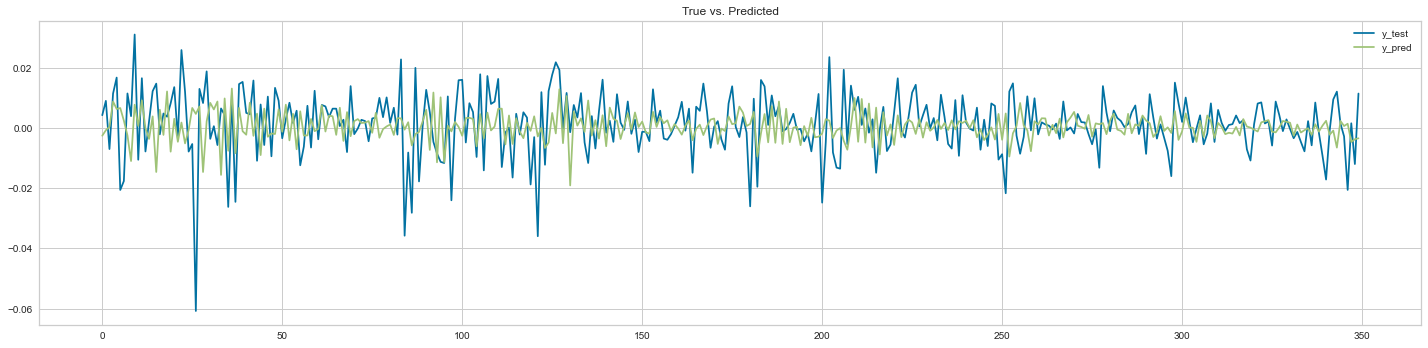

Validation Scores
root mean squared error: 0.0109022507
mean squared error: 0.0001188591
mean absolute error: 0.0082330042
R2: -0.1309270825


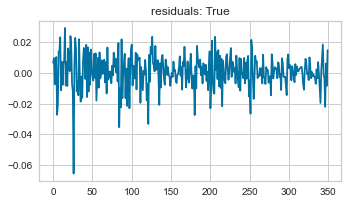

Stationarity Test Results
P-Values: 8.461688242100096e-27
Test-stats: -14.402537474760154
Time series is stationary: True


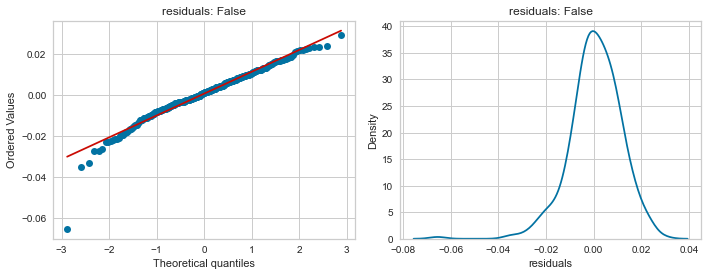

Normality Test Results
P-Values: 2.1609892224956452e-16
Test-stats: 72.14159079533769
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


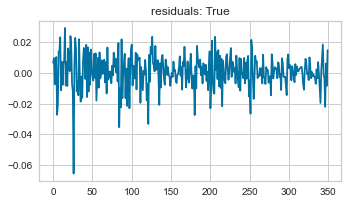

Test for Heteroskedasticity
Test p-value: 0.00025630578117530366
Heteroskedasticity is present: True


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 2.172 < 2.5
First order autocorrlation is not present: : True


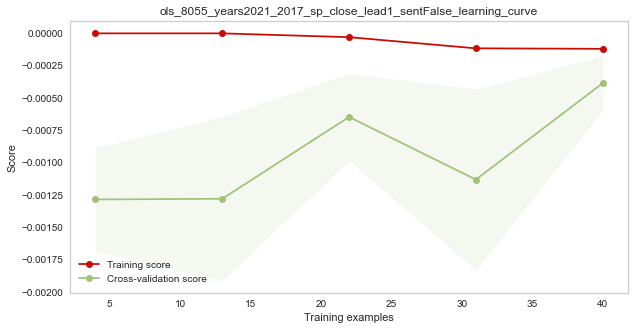

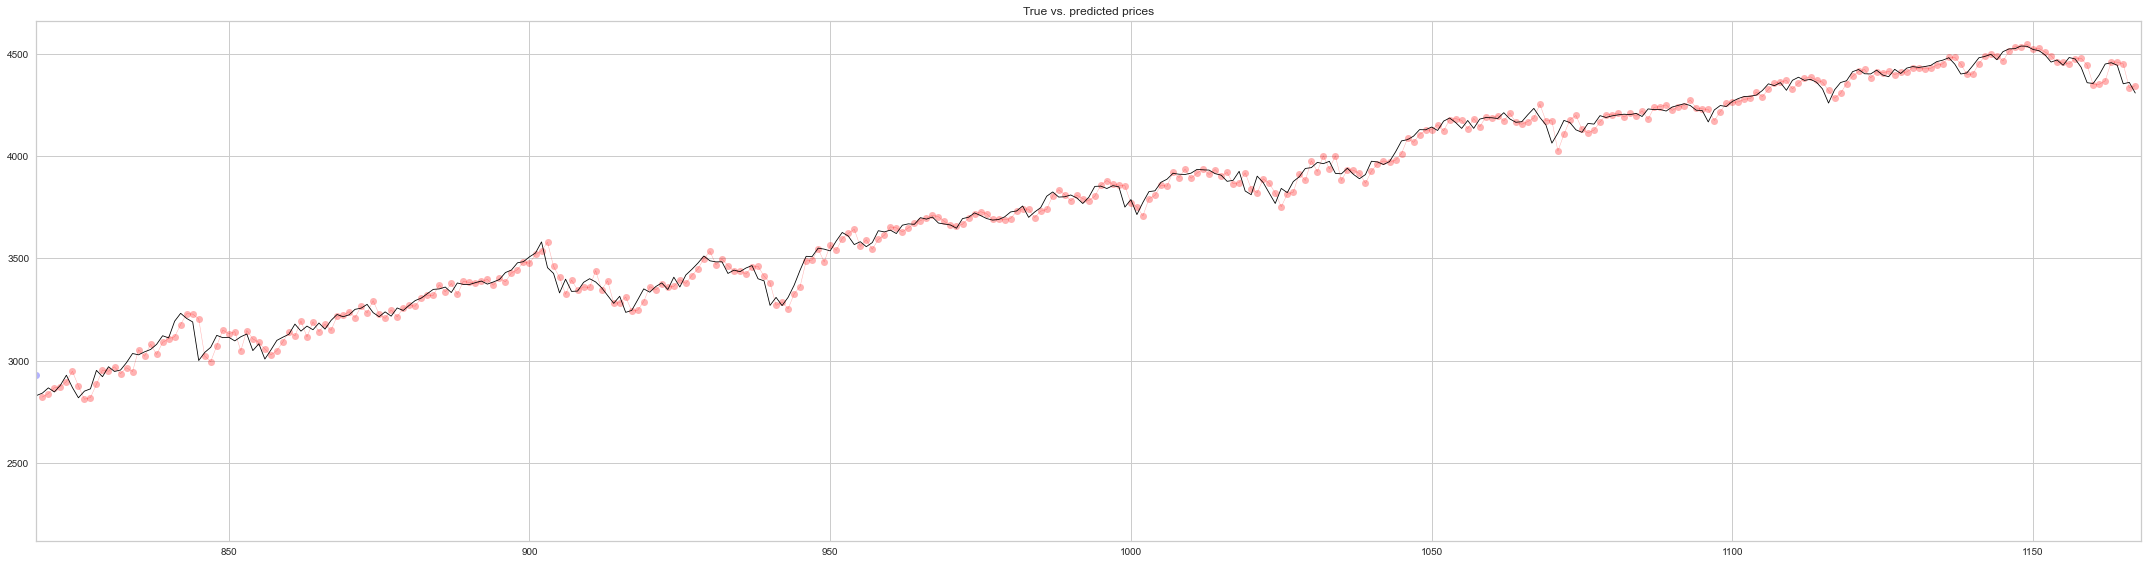

Validation Scores Test Data
mean squared error: 1475.7053780294
mean absolute error: 29.6250289399
mean absolute error in %: 0.009741708763475547
r2: 0.9934642573


In [80]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model,
            print_results=True)

fig_true_vs_fit = mval.get_model_performance()
stat, norm, hetero, d_watson = mval.analyse_resids()

fig_lcurve = mval.sm_learning_curve(f"{data_dict['model_metrics']['model_name']}_learning_curve", n_splits=10)
fig_prices = mval.plot_results_on_price_scale(df_w,
                                              df_train,
                                              sp_true_vals=data_dict["data"]["sp_true_vals"], show_pred_only=True)

# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=d_watson)

# model performance
data_dict["model_metrics"].update(rmse=mval.rmse)
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [81]:
save_model(model, df_train, data_dict, fig_true_vs_fit, fig_lcurve, fig_prices, OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-22_ols_8055_years2021_2017_sp_close_lead1_sentFalse"? (y/n)


 y
DIR EXISTS: DO YOU WANT TO REPLACE IT? (y/n) y
